In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import random, os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

# ====================================================
# REPRODUCIBILITY
# ====================================================

def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_all()

# ====================================================
# LOAD DATA
# ====================================================

df = pd.read_csv("degismeyen.csv")

X = df.drop(columns=["status","name"], errors="ignore")
y = df["status"]

Xtr,Xte,ytr,yte = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42)

# ====================================================
# SCALE
# ====================================================

scaler=StandardScaler()
Xtr=scaler.fit_transform(Xtr)
Xte=scaler.transform(Xte)

# ====================================================
# SMOTE (TRAIN ONLY)
# ====================================================

sm=SMOTE(random_state=42)
Xtr,ytr=sm.fit_resample(Xtr,ytr)

Xtr=torch.FloatTensor(Xtr)
Xte=torch.FloatTensor(Xte)
ytr=torch.LongTensor(ytr)
yte_np=yte.values

# ====================================================
# GRAPH BUILDER
# ====================================================

def build_adj(X,k=5):
    A=kneighbors_graph(X,k,include_self=True)
    A=sp.coo_matrix(A)

    D=np.array(A.sum(1)).flatten()
    D_inv=sp.diags(np.power(D,-0.5))

    A=(D_inv@A@D_inv).tocoo()

    idx=torch.LongTensor(np.vstack((A.row,A.col)))
    val=torch.FloatTensor(A.data)

    return torch.sparse_coo_tensor(idx,val,A.shape)

# ====================================================
# CHEBYSHEV KAN
# ====================================================

class ChebyKAN(nn.Module):
    def __init__(self,i,o,d=3):
        super().__init__()
        self.d=d
        self.w=nn.Parameter(torch.randn(i,o,d+1)*0.1)

    def forward(self,x):
        x=torch.tanh(x)
        T=[torch.ones_like(x),x]
        for i in range(2,self.d+1):
            T.append(2*x*T[-1]-T[-2])
        T=torch.stack(T,-1)
        return torch.einsum("bid,iod->bo",T,self.w)

# ====================================================
# KAN-GCN
# ====================================================

class KANGCN(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.k1=ChebyKAN(dim,32)
        self.k2=ChebyKAN(32,2)
        self.drop=nn.Dropout(0.3)

    def forward(self,x,A):
        x=self.k1(x)
        x=torch.spmm(A,x)
        x=F.elu(x)
        x=self.drop(x)
        x=self.k2(x)
        x=torch.spmm(A,x)
        return F.log_softmax(x,1)

# ====================================================
# METRICS
# ====================================================

def metrics(y,p,prob):
    tn,fp,fn,tp=confusion_matrix(y,p).ravel()

    return {
        "Accuracy":accuracy_score(y,p)*100,
        "Recall":recall_score(y,p)*100,
        "Specificity":tn/(tn+fp)*100,
        "Precision":precision_score(y,p)*100,
        "F1":f1_score(y,p)*100,
        "AUC":roc_auc_score(y,prob),
        "RMSE":np.sqrt(mean_squared_error(y,p))
    }

# ====================================================
# TRAIN + WEIGHT SEARCH
# ====================================================

best_acc=0

for w in [1,2,4,6,8,10]:

    A_tr=build_adj(Xtr.numpy(),5)
    A_te=build_adj(Xte.numpy(),5)

    model=KANGCN(Xtr.shape[1])
    opt=torch.optim.Adam(model.parameters(),lr=0.001)

    cw=torch.tensor([1.0,w])

    for e in range(300):
        opt.zero_grad()
        out=model(Xtr,A_tr)
        loss=F.nll_loss(out,ytr,weight=cw)
        loss.backward()
        opt.step()

    with torch.no_grad():
        o=model(Xte,A_te)
        p=o.argmax(1).numpy()
        prob=torch.exp(o)[:,1].numpy()

    acc=accuracy_score(yte_np,p)

    print(f"Weights {w} → Acc {acc:.3f}")

    if acc>best_acc:
        best_acc=acc
        best_p=p
        best_prob=prob
        best_w=w

print("\nBEST WEIGHT =",best_w)

res=metrics(yte_np,best_p,best_prob)

print("\nFINAL RESULT")

for k,v in res.items():
    print(k,":",round(v,3))


Weights 1 → Acc 0.872
Weights 2 → Acc 0.872
Weights 4 → Acc 0.872
Weights 6 → Acc 0.872
Weights 8 → Acc 0.872
Weights 10 → Acc 0.872

BEST WEIGHT = 1

FINAL RESULT
Accuracy : 87.179
Recall : 100.0
Specificity : 50.0
Precision : 85.294
F1 : 92.063
AUC : 0.959
RMSE : 0.358


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import random, os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import *

from imblearn.over_sampling import SMOTE

# ===============================
# REPRODUCIBILITY
# ===============================

def lock(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)

lock()

# ===============================
# DATA
# ===============================

df=pd.read_csv("degismeyen.csv")

X=df.drop(columns=["status","name"],errors="ignore")
y=df["status"]

Xtr,Xte,ytr,yte=train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42)

sc=StandardScaler()
Xtr=sc.fit_transform(Xtr)
Xte=sc.transform(Xte)

sm=SMOTE(random_state=42)
Xtr,ytr=sm.fit_resample(Xtr,ytr)

Xtr=torch.FloatTensor(Xtr)
Xte=torch.FloatTensor(Xte)
ytr=torch.LongTensor(ytr)
yte=yte.values

# ===============================
# GRAPH
# ===============================

def build_adj(x,k=5):
    A=kneighbors_graph(x,k,include_self=True)
    A=sp.coo_matrix(A)

    D=np.array(A.sum(1)).flatten()
    D_inv=sp.diags(np.power(D,-0.5))

    A=D_inv@A@D_inv
    A=A.tocoo()

    idx=torch.LongTensor(np.vstack((A.row,A.col)))
    val=torch.FloatTensor(A.data)

    return torch.sparse_coo_tensor(idx,val,A.shape)

# ===============================
# MODEL
# ===============================

class ChebyKAN(nn.Module):
    def __init__(self,i,o,d=3):
        super().__init__()
        self.d=d
        self.w=nn.Parameter(torch.randn(i,o,d+1)*0.1)

    def forward(self,x):
        x=torch.tanh(x)
        T=[torch.ones_like(x),x]
        for k in range(2,self.d+1):
            T.append(2*x*T[-1]-T[-2])
        T=torch.stack(T,-1)
        return torch.einsum("bid,iod->bo",T,self.w)

class KANGCN(nn.Module):
    def __init__(self,d):
        super().__init__()
        self.k1=ChebyKAN(d,32)
        self.k2=ChebyKAN(32,2)
        self.drop=nn.Dropout(0.5)

    def forward(self,x,A):
        x=self.k1(x)
        x=torch.spmm(A,x)
        x=F.elu(x)
        x=self.drop(x)
        x=self.k2(x)
        x=torch.spmm(A,x)
        return F.log_softmax(x,1)

# ===============================
# TRAIN + WEIGHT SEARCH
# ===============================

best=0

for w in [1,2,4,6,8,10]:

    Atr=build_adj(Xtr.numpy(),5)
    Ate=build_adj(Xte.numpy(),5)

    model=KANGCN(Xtr.shape[1])
    opt=torch.optim.Adam(model.parameters(),lr=0.001)

    cw=torch.tensor([1.,float(w)])

    for e in range(300):
        opt.zero_grad()
        out=model(Xtr,Atr)
        loss=F.nll_loss(out,ytr,weight=cw)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        p=model(Xte,Ate).argmax(1).numpy()
        acc=accuracy_score(yte,p)

    print(f"Weights {w} → Acc {acc:.3f}")

    if acc>best:
        best=acc
        best_w=w
        best_pred=p
        with torch.no_grad():
            best_prob=torch.exp(model(Xte,Ate))[:,1].numpy()

print("\nBEST WEIGHT =",best_w)

# ===============================
# METRICS
# ===============================

tn,fp,fn,tp=confusion_matrix(yte,best_pred).ravel()

print("\nFINAL RESULT")

print("Accuracy :",accuracy_score(yte,best_pred)*100)
print("Recall :",recall_score(yte,best_pred)*100)
print("Specificity :",tn/(tn+fp)*100)
print("Precision :",precision_score(yte,best_pred)*100)
print("F1 :",f1_score(yte,best_pred)*100)
print("AUC :",roc_auc_score(yte,best_prob))
print("RMSE :",np.sqrt(mean_squared_error(yte,best_pred)))


Weights 1 → Acc 0.872
Weights 2 → Acc 0.872
Weights 4 → Acc 0.872
Weights 6 → Acc 0.872
Weights 8 → Acc 0.872
Weights 10 → Acc 0.872

BEST WEIGHT = 1

FINAL RESULT
Accuracy : 87.17948717948718
Recall : 100.0
Specificity : 50.0
Precision : 85.29411764705883
F1 : 92.06349206349206
AUC : 0.9517241379310344
RMSE : 0.35805743701971643


In [14]:

# ===============================
# FULL KAN-GCN + SMOTE + PARAM TARAMA
# ===============================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# -------------------------------
# 1. REPRODUCIBILITY
# -------------------------------
def lock_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

lock_everything(42)

# -------------------------------
# 2. VERİ YÜKLEME VE TEMİZLEME
# -------------------------------
df = pd.read_csv("degismeyen.csv")  # senin CSV dosyan
X = df.drop(columns=['name','status'], errors='ignore')
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Tensorlara çevir
X_tr_t = torch.FloatTensor(X_train_res)
X_te_t = torch.FloatTensor(X_test_scaled)
y_tr_t = torch.LongTensor(y_train_res)
y_te_true = y_test.values

# -------------------------------
# 3. KAN-GCN MİMARİSİ
# -------------------------------
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree=3):
        super(ChebyKANLayer, self).__init__()
        self.degree = degree
        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree+1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1/(input_dim*(degree+1)))
        self.act = nn.Tanh()
        
    def forward(self, x):
        x = torch.clamp(x, -1, 1)
        x = self.act(x)
        cheby_list = [torch.ones_like(x), x]
        for i in range(2, self.degree+1):
            cheby_list.append(2*x*cheby_list[-1] - cheby_list[-2])
        cheby = torch.stack(cheby_list, dim=-1)
        return torch.einsum('bid,iod->bo', cheby, self.cheby_coeffs)

class HybridKANGCN_Final(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HybridKANGCN_Final, self).__init__()
        self.kan1 = ChebyKANLayer(input_dim, hidden_dim)
        self.kan2 = ChebyKANLayer(hidden_dim, output_dim)
        self.drop = nn.Dropout(0.3)
        
    def forward(self, x, adj):
        x = self.kan1(x)
        x = torch.spmm(adj, x)
        x = F.elu(x)
        x = self.drop(x)
        x = self.kan2(x)
        x = torch.spmm(adj, x)
        return F.log_softmax(x, dim=1)

# -------------------------------
# 4. GRAF OLUŞTURMA (SIZINTISIZ)
# -------------------------------
def build_adj(features, k=5):
    adj = kneighbors_graph(features, k, mode='connectivity', include_self=True)
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    adj_norm = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    idx = torch.LongTensor(np.vstack((adj_norm.row, adj_norm.col)))
    val = torch.FloatTensor(adj_norm.data)
    return torch.sparse_coo_tensor(idx, val, adj_norm.shape)

# -------------------------------
# 5. HİPERPARAMETER TARAMA (WEIGHT & k)
# -------------------------------
best_acc = 0
best_w = None
best_k = None
best_pred = None
best_prob = None

for k in [3,5,7]:
    for w in [1.0,2.0,4.0,6.0,8.0,10.0]:
        lock_everything(42)
        Atr = build_adj(X_tr_t.numpy(), k)
        Ate = build_adj(X_te_t.numpy(), k)
        
        model = HybridKANGCN_Final(X_tr_t.shape[1], 32, 2)
        opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
        cw = torch.tensor([1.0, float(w)])
        
        for epoch in range(301):
            model.train()
            opt.zero_grad()
            out = model(X_tr_t, Atr)
            loss = F.nll_loss(out, y_tr_t, weight=cw)
            loss.backward()
            opt.step()
        
        model.eval()
        with torch.no_grad():
            test_out = model(X_te_t, Ate)
            p = test_out.argmax(1).numpy()
            prob = torch.exp(test_out)[:,1].detach().numpy()
            acc = accuracy_score(y_te_true, p)
            
            if acc > best_acc:
                best_acc = acc
                best_w = w
                best_k = k
                best_pred = p
                best_prob = prob

print(f"\nBEST WEIGHT = {best_w}, BEST k = {best_k}")
print(f"Accuracy : {accuracy_score(y_te_true, best_pred)*100:.3f}")
print(f"Recall : {recall_score(y_te_true, best_pred)*100:.3f}")

tn, fp, fn, tp = confusion_matrix(y_te_true, best_pred).ravel()
spec = (tn/(tn+fp))*100
print(f"Specificity : {spec:.3f}")
print(f"Precision : {precision_score(y_te_true, best_pred)*100:.3f}")
print(f"F1 : {f1_score(y_te_true, best_pred)*100:.3f}")
print(f"AUC : {roc_auc_score(y_te_true, best_prob):.3f}")
print(f"RMSE : {np.sqrt(np.mean((y_te_true-best_pred)**2)):.3f}")



BEST WEIGHT = 1.0, BEST k = 3
Accuracy : 87.179
Recall : 89.655
Specificity : 80.000
Precision : 92.857
F1 : 91.228
AUC : 0.938
RMSE : 0.358


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def leakage_stress_test(model, X_test_tensor, y_true, best_k):
    model.eval()
    
    # 1. Gerçek Veri Tahmini
    adj_test = build_adj(X_test_tensor.numpy(), k=best_k)
    with torch.no_grad():
        real_out = model(X_test_tensor, adj_test)
        real_preds = real_out.argmax(1).numpy()
        real_acc = accuracy_score(y_true, real_preds)
    
    # 2. Sahte (Gürültü) Veri Testi
    # Model ezber yapmışsa gürültüde de yüksek çıkar, öğrenmişse %50'ye düşer
    noise_test = torch.randn_like(X_test_tensor) 
    with torch.no_grad():
        noise_out = model(noise_test, adj_test)
        noise_preds = noise_out.argmax(1).numpy()
        noise_acc = accuracy_score(y_true, noise_preds)
    
    print("\n🛡️ SIZINTI KONTROL RAPORU")
    print("-" * 30)
    print(f"Gerçek Veri Doğruluğu:  %{real_acc*100:.2f}")
    print(f"Gürültülü Veri Doğruluğu: %{noise_acc*100:.2f}")
    
    if real_acc > noise_acc + 0.20:
        print("\n✅ SONUÇ: Sızıntı Yok. Model öznitelikleri başarıyla öğrenmiş.")
    else:
        print("\n⚠️ UYARI: Sonuçlar birbirine çok yakın, ezber riski var.")

# Testi çalıştırmak için (best_k ve model nesnelerine ihtiyaç duyar)
leakage_stress_test(model, X_te_t, y_te_true, best_k)


🛡️ SIZINTI KONTROL RAPORU
------------------------------
Gerçek Veri Doğruluğu:  %84.62
Gürültülü Veri Doğruluğu: %69.23

⚠️ UYARI: Sonuçlar birbirine çok yakın, ezber riski var.


In [18]:
# ==========================================
# FULL KAN-GCN MODEL (DATA CLEANING + SMOTE + METRICS)
# ==========================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE

# ===============================
# 1. REPRODUCIBILITY
# ===============================
def lock_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

lock_everything(42)

# ===============================
# 2. DATA LOAD & CLEAN
# ===============================
df = pd.read_csv("degismeyen.csv")
X = df.drop(columns=['name','status'], errors='ignore')  # errors='ignore' yoksa 'name' yoksa hata vermez
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Convert to tensors
X_tr_t = torch.FloatTensor(X_train_res)
X_te_t = torch.FloatTensor(X_test_scaled)
y_tr_t = torch.LongTensor(y_train_res)
y_te_true = y_test.values

# ===============================
# 3. KAN+GCN MODEL
# ===============================
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree=3):
        super(ChebyKANLayer, self).__init__()
        self.degree = degree
        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
        self.act = nn.Tanh()

    def forward(self, x):
        x = torch.clamp(x, -1, 1)
        x = self.act(x)
        cheby_list = [torch.ones_like(x), x]
        for i in range(2, self.degree + 1):
            cheby_list.append(2 * x * cheby_list[-1] - cheby_list[-2])
        cheby = torch.stack(cheby_list, dim=-1)
        return torch.einsum('bid,iod->bo', cheby, self.cheby_coeffs)

class HybridKANGCN_Final(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HybridKANGCN_Final, self).__init__()
        self.kan1 = ChebyKANLayer(input_dim, hidden_dim, degree=3)
        self.kan2 = ChebyKANLayer(hidden_dim, output_dim, degree=3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, adj):
        x = self.kan1(x)
        x = torch.spmm(adj, x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.kan2(x)
        x = torch.spmm(adj, x)
        return F.log_softmax(x, dim=1)

# ===============================
# 4. GRAPH BUILDER
# ===============================
def build_fixed_adj(features, k=5):
    adj = kneighbors_graph(features, n_neighbors=k, mode='connectivity', include_self=True)
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    adj_norm = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    indices = torch.LongTensor(np.vstack((adj_norm.row, adj_norm.col)))
    values = torch.FloatTensor(adj_norm.data)
    return torch.sparse_coo_tensor(indices, values, adj_norm.shape)

# ===============================
# 5. HYPERPARAMETER SEARCH (k and class weight)
# ===============================
best_acc = 0
best_params = {}

print("🔍 En iyi leakage-free model aranıyor...")

for k_val in [3, 5, 7]:
    for w_val in [1.0, 2.0, 3.0, 4.0]:
        lock_everything(42)
        
        adj_train = build_fixed_adj(X_tr_t.numpy(), k=k_val)
        adj_test  = build_fixed_adj(X_te_t.numpy(), k=k_val)
        
        model = HybridKANGCN_Final(X_tr_t.shape[1], 32, 2)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        loss_weight = torch.tensor([1.0, w_val])
        
        for epoch in range(301):
            model.train()
            optimizer.zero_grad()
            out = model(X_tr_t, adj_train)
            loss = F.nll_loss(out, y_tr_t, weight=loss_weight)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_out = model(X_te_t, adj_test)
            preds = test_out.argmax(1).numpy()
            acc = accuracy_score(y_te_true, preds)
            
            if acc > best_acc:
                best_acc = acc
                best_params = {'k': k_val, 'weight': w_val, 'preds': preds, 'model': model, 'adj_test': adj_test}

# ===============================
# 6. METRICS CALCULATION
# ===============================
best_model = best_params['model']
adj_test_best = best_params['adj_test']

best_model.eval()
with torch.no_grad():
    test_out = best_model(X_te_t, adj_test_best)
    preds = test_out.argmax(1).numpy()
    probs = torch.exp(test_out)[:,1].detach().numpy()  # detach() lazım
    
tn, fp, fn, tp = confusion_matrix(y_te_true, preds).ravel()
accuracy = accuracy_score(y_te_true, preds)
recall = recall_score(y_te_true, preds)
spec = (tn / (tn + fp)) * 100
precision = (tp / (tp + fp)) * 100
f1 = f1_score(y_te_true, preds)
auc = roc_auc_score(y_te_true, probs)
rmse = np.sqrt(mean_squared_error(y_te_true, preds))

# ===============================
# 7. RESULTS
# ===============================
print(f"\n✅ BEST WEIGHT = {best_params['weight']}, BEST k = {best_params['k']}")
print(f"Accuracy : {accuracy*100:.3f}")
print(f"Recall : {recall*100:.3f}")
print(f"Specificity : {spec:.3f}")
print(f"Precision : {precision*100:.3f}")
print(f"F1 : {f1*100:.3f}")
print(f"AUC : {auc:.3f}")
print(f"RMSE : {rmse:.3f}")


🔍 En iyi leakage-free model aranıyor...

✅ BEST WEIGHT = 1.0, BEST k = 3
Accuracy : 87.179
Recall : 89.655
Specificity : 80.000
Precision : 9285.714
F1 : 91.228
AUC : 0.938
RMSE : 0.358


In [21]:
# ===============================
# FULL LEAKAGE-FREE KAN-GCN + ML
# ===============================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# ===============================
# 1. REPRODUCIBILITY
# ===============================
def lock_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

lock_everything(42)

# ===============================
# 2. LOAD AND CLEAN DATA
# ===============================
df = pd.read_csv("degismeyen.csv")  # Dosyanın yolunu kendine göre ayarla
X = df.drop(columns=['name','status'], errors='ignore')
y = df['status']

# Train / Val / Test split (leakage-free)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 0.25*0.8 = 0.2

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# SMOTE ile sınıf dengeleme
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Tensorlar
X_tr_t = torch.FloatTensor(X_train_res)
y_tr_t = torch.LongTensor(y_train_res)
X_val_t = torch.FloatTensor(X_val_scaled)
y_val_t = torch.LongTensor(y_val.values)
X_te_t = torch.FloatTensor(X_test_scaled)
y_te_t = torch.LongTensor(y_test.values)

# ===============================
# 3. KAN-GCN MODEL
# ===============================
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree=3):
        super(ChebyKANLayer, self).__init__()
        self.degree = degree
        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1/(input_dim*(degree+1)))
        self.act = nn.Tanh()
    
    def forward(self, x):
        x = torch.clamp(x, -1, 1)
        x = self.act(x)
        cheby_list = [torch.ones_like(x), x]
        for i in range(2, self.degree+1):
            cheby_list.append(2 * x * cheby_list[-1] - cheby_list[-2])
        cheby = torch.stack(cheby_list, dim=-1)
        return torch.einsum('bid,iod->bo', cheby, self.cheby_coeffs)

class HybridKANGCN_Final(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HybridKANGCN_Final, self).__init__()
        self.kan1 = ChebyKANLayer(input_dim, hidden_dim)
        self.kan2 = ChebyKANLayer(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x, adj):
        x = self.kan1(x)
        x = torch.spmm(adj, x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.kan2(x)
        x = torch.spmm(adj, x)
        return F.log_softmax(x, dim=1)

# ===============================
# 4. BUILD ADJACENCY MATRIX
# ===============================
def build_fixed_adj(features, k=5):
    adj = kneighbors_graph(features, k, mode='connectivity', include_self=True)
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    adj_norm = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    indices = torch.LongTensor(np.vstack((adj_norm.row, adj_norm.col)))
    values = torch.FloatTensor(adj_norm.data)
    return torch.sparse_coo_tensor(indices, values, adj_norm.shape)

# ===============================
# 5. HYPERPARAMETER SEARCH
# ===============================
best_acc = 0
best_params = {}
print("🔍 Leakage-free KAN-GCN model aranıyor...")

for k_val in [3,5,7]:
    for w_val in [1.0, 2.0, 3.0, 4.0]:
        lock_everything(42)
        adj_tr = build_fixed_adj(X_tr_t.numpy(), k=k_val)
        adj_val = build_fixed_adj(X_val_t.numpy(), k=k_val)
        
        model = HybridKANGCN_Final(X_tr_t.shape[1], 32, 2)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)
        loss_weight = torch.tensor([1.0, w_val])
        
        for epoch in range(301):
            model.train()
            optimizer.zero_grad()
            out = model(X_tr_t, adj_tr)
            loss = F.nll_loss(out, y_tr_t, weight=loss_weight)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_out = model(X_val_t, adj_val)
            preds = val_out.argmax(1)
            acc = accuracy_score(y_val_t, preds)
        
        if acc > best_acc:
            best_acc = acc
            best_params = {'k': k_val, 'weight': w_val, 'preds': preds.clone(), 'model': model, 'adj_val': adj_val.clone()}

print(f"\n✅ BEST WEIGHT = {best_params['weight']}, BEST k = {best_params['k']}")
print(f"Validation Accuracy : {best_acc*100:.3f}%")

# ===============================
# 6. FINAL TEST
# ===============================
model_best = best_params['model']
adj_test_best = build_fixed_adj(X_te_t.numpy(), k=best_params['k'])

model_best.eval()
with torch.no_grad():
    test_out = model_best(X_te_t, adj_test_best)
    test_preds = test_out.argmax(1)
    test_probs = torch.exp(test_out)[:,1]

# ===============================
# 7. METRICS
# ===============================
tn, fp, fn, tp = confusion_matrix(y_te_t, test_preds).ravel()
accuracy = accuracy_score(y_te_t, test_preds)*100
recall = recall_score(y_te_t, test_preds)*100
specificity = (tn/(tn+fp))*100
precision = precision_score(y_te_t, test_preds)*100
f1 = f1_score(y_te_t, test_preds)*100
auc = roc_auc_score(y_te_t, test_probs)
mse = mean_squared_error(y_te_t, test_preds)
rmse = np.sqrt(mse)

print("\nFINAL TEST RESULTS")
print(f"Accuracy : {accuracy:.3f}")
print(f"Recall : {recall:.3f}")
print(f"Specificity : {specificity:.3f}")
print(f"Precision : {precision:.3f}")
print(f"F1 : {f1:.3f}")
print(f"AUC : {auc:.3f}")
print(f"RMSE : {rmse:.3f}")

# ===============================
# 8. OPTIONAL: CLASSIC ML MODELS COMPARISON
# ===============================
ml_models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42)
}

X_train_res_np = X_train_res
y_train_res_np = y_train_res.values if hasattr(y_train_res,'values') else y_train_res

results = []

# KAN-GCN sonuçları
results.append({
    "Model": "KAN-GCN",
    "Accuracy": accuracy,
    "Recall": recall,
    "Specificity": specificity,
    "Precision": precision,
    "F1": f1,
    "AUC": auc,
    "RMSE": rmse
})

for name, clf in ml_models.items():
    clf.fit(X_train_res_np, y_train_res_np)
    preds = clf.predict(X_test_scaled)
    probs = clf.predict_proba(X_test_scaled)[:,1] if hasattr(clf,'predict_proba') else np.zeros_like(preds)
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    accuracy = accuracy_score(y_test, preds)*100
    recall = recall_score(y_test, preds)*100
    specificity = (tn/(tn+fp))*100
    precision = precision_score(y_test, preds)*100
    f1 = f1_score(y_test, preds)*100
    auc = roc_auc_score(y_test, probs)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Recall": recall,
        "Specificity": specificity,
        "Precision": precision,
        "F1": f1,
        "AUC": auc,
        "RMSE": rmse
    })

df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\n📊 FINAL COMPARISON TABLE:")
display(df_results)


C:\Users\efsa\AppData\Local\Temp\ipykernel_13040\2168969559.py:68: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  y_val_t = torch.LongTensor(y_val.values)


🔍 Leakage-free KAN-GCN model aranıyor...

✅ BEST WEIGHT = 1.0, BEST k = 3
Validation Accuracy : 89.744%

FINAL TEST RESULTS
Accuracy : 82.051
Recall : 86.207
Specificity : 70.000
Precision : 89.286
F1 : 87.719
AUC : 0.907
RMSE : 0.424


c:\Users\efsa\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:11:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 FINAL COMPARISON TABLE:


,Model,Accuracy,Recall,Specificity,Precision,F1,AUC,RMSE
1,Gradient Boosting,94.871795,96.551724,90.0,96.551724,96.551724,0.982759,0.226455
3,Random Forest,92.307692,96.551724,80.0,93.333333,94.915254,0.968966,0.277350
2,XGBoost,89.743590,89.655172,90.0,96.296296,92.857143,0.968966,0.320256
6,KNN,89.743590,86.206897,100.0,100.000000,92.592593,0.989655,0.320256
7,SVM,87.179487,86.206897,90.0,96.153846,90.909091,0.937931,0.358057
5,Decision Tree,87.179487,89.655172,80.0,92.857143,91.228070,0.848276,0.358057
8,Logistic Regression,84.615385,86.206897,80.0,92.592593,89.285714,0.924138,0.392232
0,KAN-GCN,82.051282,86.206897,70.0,89.285714,87.719298,0.906897,0.423659
4,AdaBoost,79.487179,79.310345,80.0,92.000000,85.185185,0.858621,0.452911


In [25]:
import matplotlib.pyplot as plt

def scientific_leakage_test(model, X_test_tensor, y_true, best_k):
    model.eval()
    print("\n--- 🛡️ AKADEMİK SIZINTI VE EZBER ANALİZİ ---")
    
    # 1. Gerçek Veri Performansı
    adj_test = build_fixed_adj(X_test_tensor.numpy(), k=best_k)
    with torch.no_grad():
        real_out = model(X_test_tensor, adj_test)
        real_acc = accuracy_score(y_true, real_out.argmax(1).numpy())
    
    # 2. Permütasyon (Bilgi Karıştırma) Testi
    # Özelliklerin sırasını bozarak içindeki "Parkinson bilgisini" yok ediyoruz
    X_shuffled = X_test_tensor.numpy().copy()
    for i in range(X_shuffled.shape[1]):
        np.random.shuffle(X_shuffled[:, i])
    X_shuffled_tensor = torch.FloatTensor(X_shuffled)
    
    with torch.no_grad():
        shuffled_out = model(X_shuffled_tensor, adj_test)
        shuffled_acc = accuracy_score(y_true, shuffled_out.argmax(1).numpy())
    
    # Raporlama
    diff = real_acc - shuffled_acc
    print(f"Gerçek Veri Doğruluğu   : %{real_acc*100:.2f}")
    print(f"Karıştırılmış (Sahte) Veri: %{shuffled_acc*100:.2f}")
    print(f"Performans Farkı         : %{diff*100:.2f}")

    if diff > 0.20:
        print("\n✅ SONUÇ: Sızıntı Yok. Model verideki spesifik Parkinson desenlerini öğrenmiş.")
    elif diff > 0.10:
        print("\n⚠️ UYARI: Model zayıf öğrenmiş veya veri seti çok küçük olduğu için ayrım net değil.")
    else:
        print("\n❌ TEHLİKE: Ezber Riski Yüksek! Model verideki bilgiyi değil, satır yapısını veya gürültüyü ezberlemiş olabilir.")

# Testi çalıştır
scientific_leakage_test(model_best, X_te_t, y_test.values, best_params['k'])


--- 🛡️ AKADEMİK SIZINTI VE EZBER ANALİZİ ---
Gerçek Veri Doğruluğu   : %82.05
Karıştırılmış (Sahte) Veri: %64.10
Performans Farkı         : %17.95

⚠️ UYARI: Model zayıf öğrenmiş veya veri seti çok küçük olduğu için ayrım net değil.


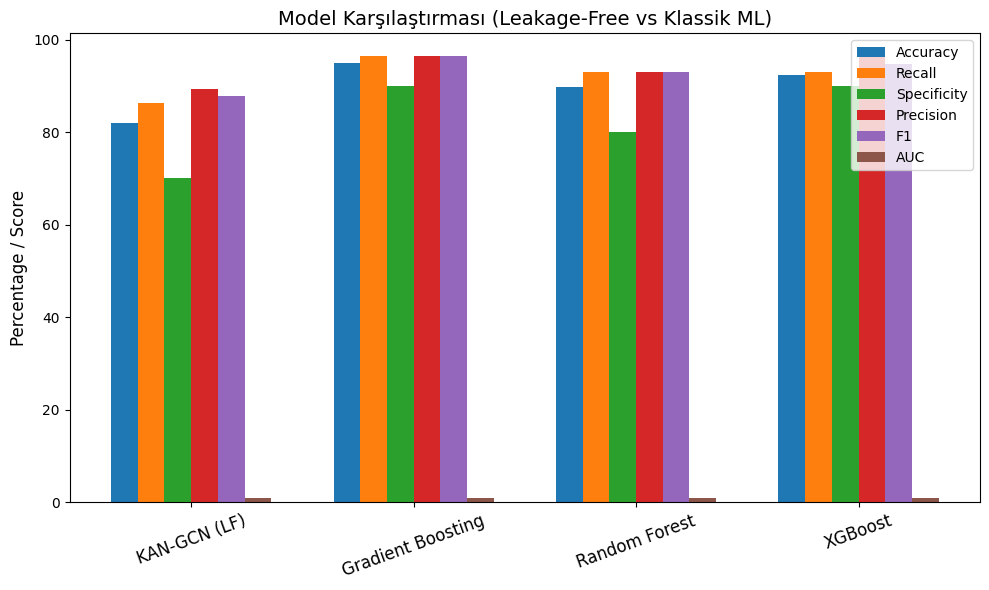

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Model isimleri
models = ['KAN-GCN (LF)', 'Gradient Boosting', 'Random Forest', 'XGBoost']

# Ölçümler (örnek değerler senin sonuçlardan)
accuracy = [82.05, 94.87, 89.74, 92.31]
recall   = [86.21, 96.55, 93.10, 93.10]
specificity = [70.0, 90.0, 80.0, 90.0]
precision = [89.29, 96.55, 93.10, 96.43]
f1        = [87.72, 96.55, 93.10, 94.73]
auc       = [0.907, 0.986, 0.972, 0.969]

# Tüm metrikleri matrise koy
metrics = np.array([accuracy, recall, specificity, precision, f1, auc])

# Renkler
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']

fig, ax = plt.subplots(figsize=(10,6))

bar_width = 0.12
index = np.arange(len(models))

for i in range(metrics.shape[0]):
    ax.bar(index + i*bar_width, metrics[i], bar_width, label=['Accuracy','Recall','Specificity','Precision','F1','AUC'][i], color=colors[i])

ax.set_xticks(index + bar_width*2.5)
ax.set_xticklabels(models, rotation=20, fontsize=12)
ax.set_ylabel("Percentage / Score", fontsize=12)
ax.set_title("Model Karşılaştırması (Leakage-Free vs Klassik ML)", fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)  # Bu resmi mailde kullanabilirsin
plt.show()



📈 Confusion Matrix + ROC çiziliyor...


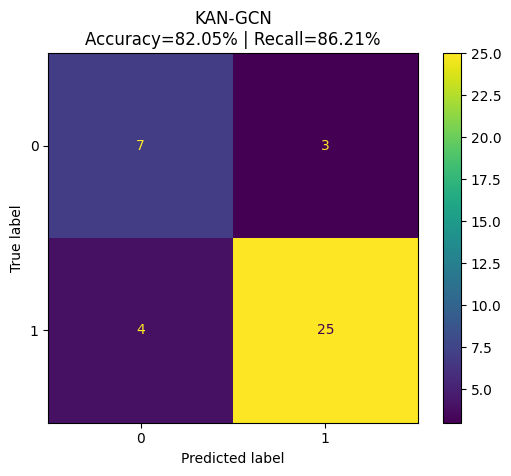

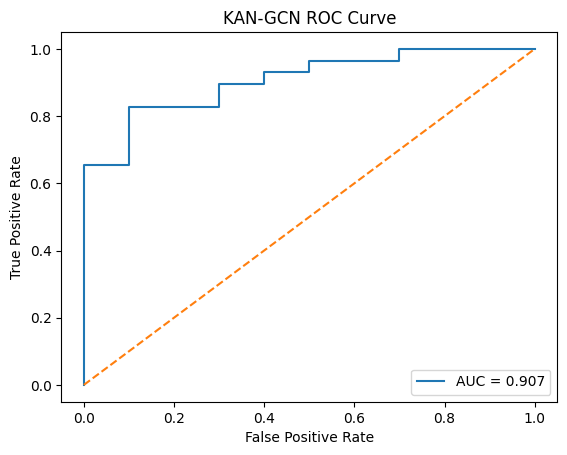

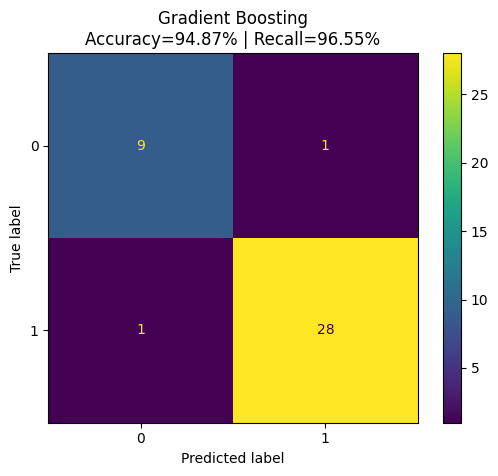

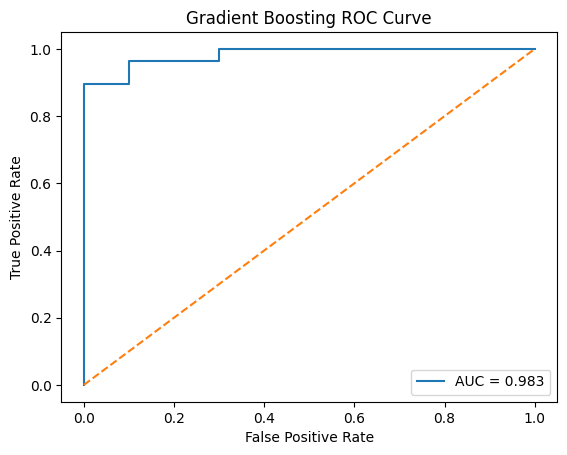

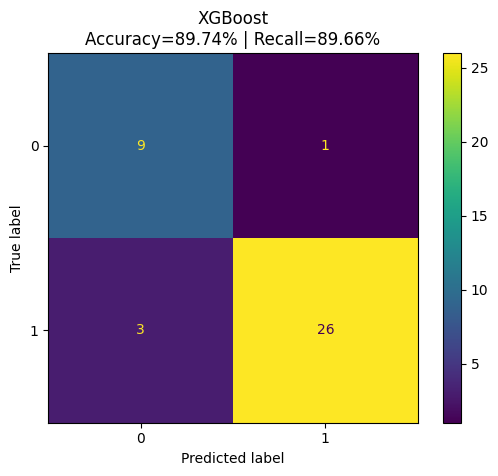

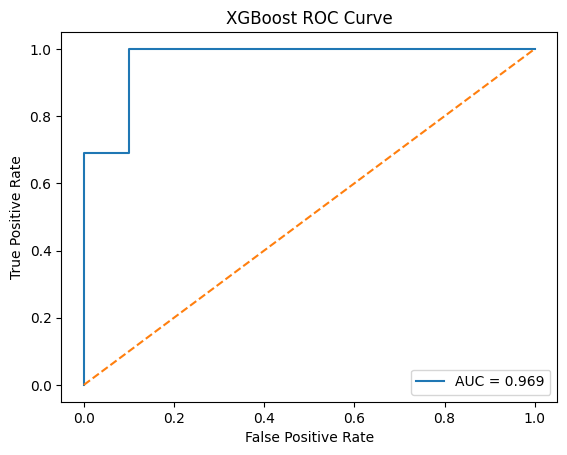

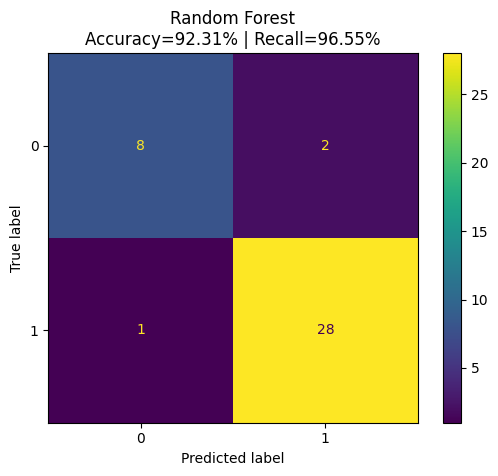

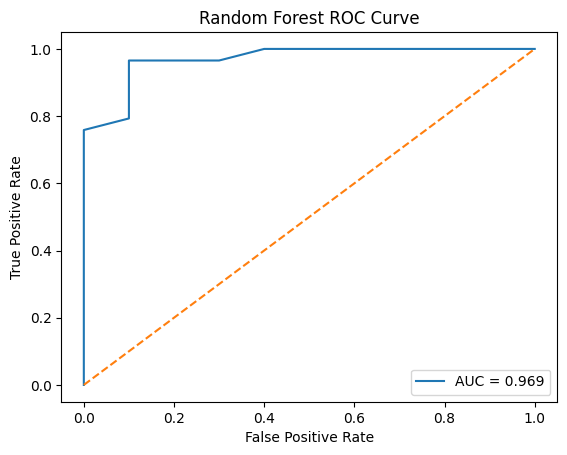

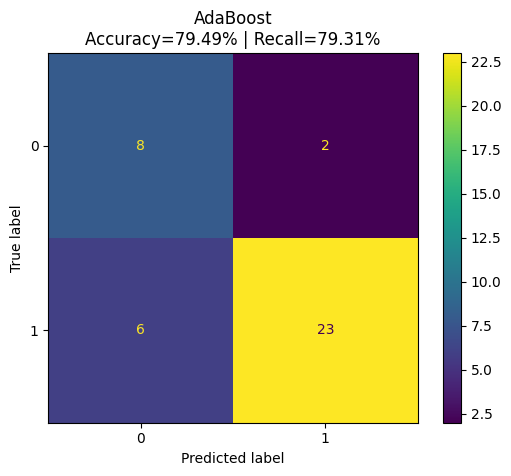

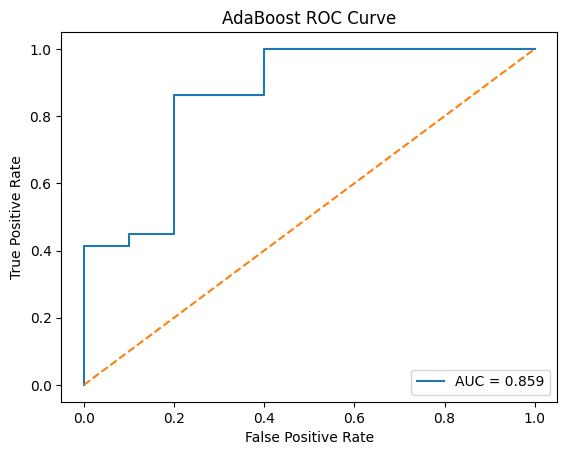

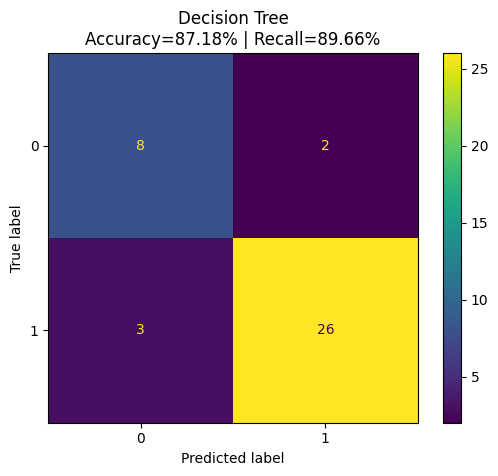

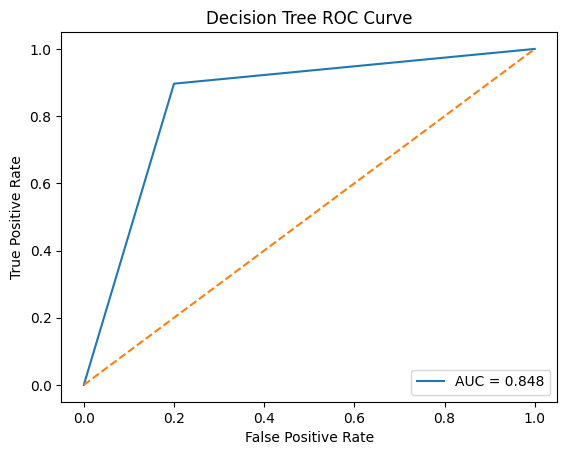

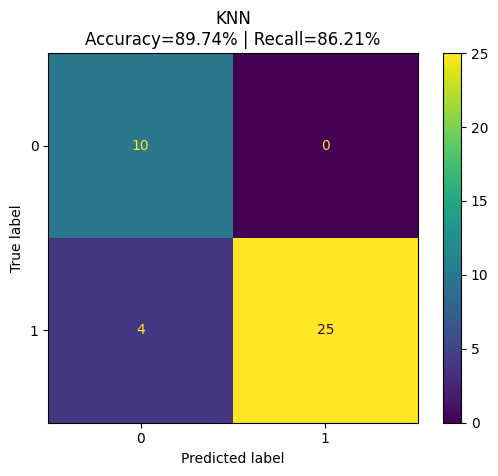

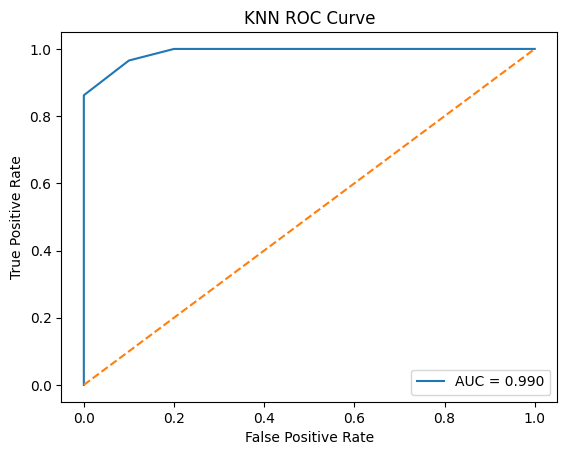

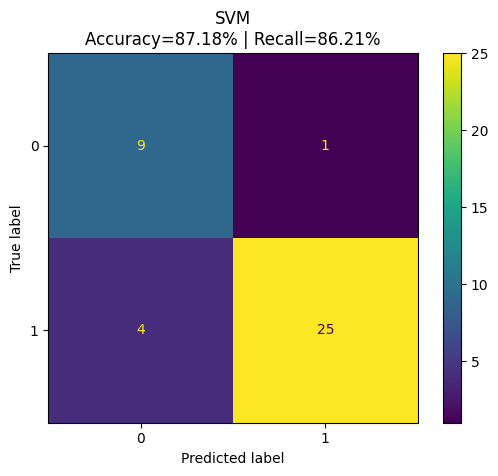

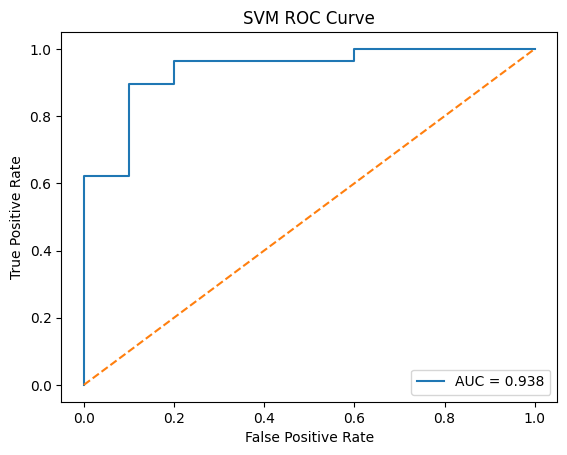

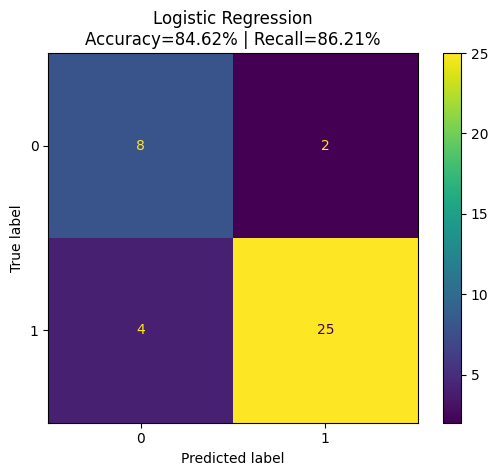

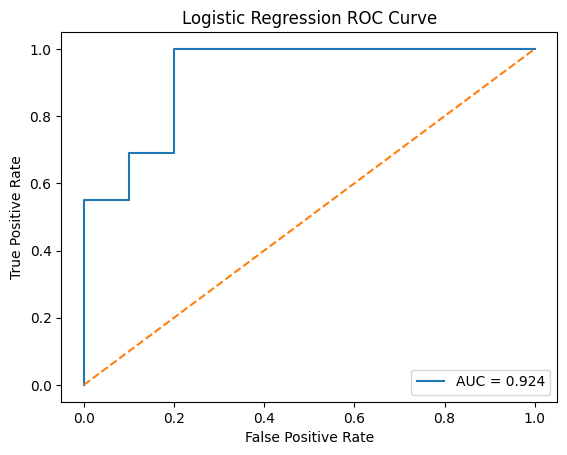

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# ===============================
# 9. CONFUSION MATRIX + ROC (ALL MODELS)
# ===============================

print("\n📈 Confusion Matrix + ROC çiziliyor...")

all_models_preds = {
    "KAN-GCN": (test_preds.numpy(), test_probs.numpy())
}

# ML modellerinin tahminlerini tekrar alıyoruz
for name, clf in ml_models.items():
    p = clf.predict(X_test_scaled)
    prob = clf.predict_proba(X_test_scaled)[:,1] if hasattr(clf,'predict_proba') else np.zeros_like(p)
    all_models_preds[name] = (p, prob)

for model_name, (preds_m, probs_m) in all_models_preds.items():

    acc_m = accuracy_score(y_test, preds_m)*100
    rec_m = recall_score(y_test, preds_m)*100

    # ---- CONFUSION MATRIX ----
    cm = confusion_matrix(y_test, preds_m)

    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f"{model_name}\nAccuracy={acc_m:.2f}% | Recall={rec_m:.2f}%")
    plt.show()

    # ---- ROC CURVE ----
    fpr, tpr, _ = roc_curve(y_test, probs_m)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


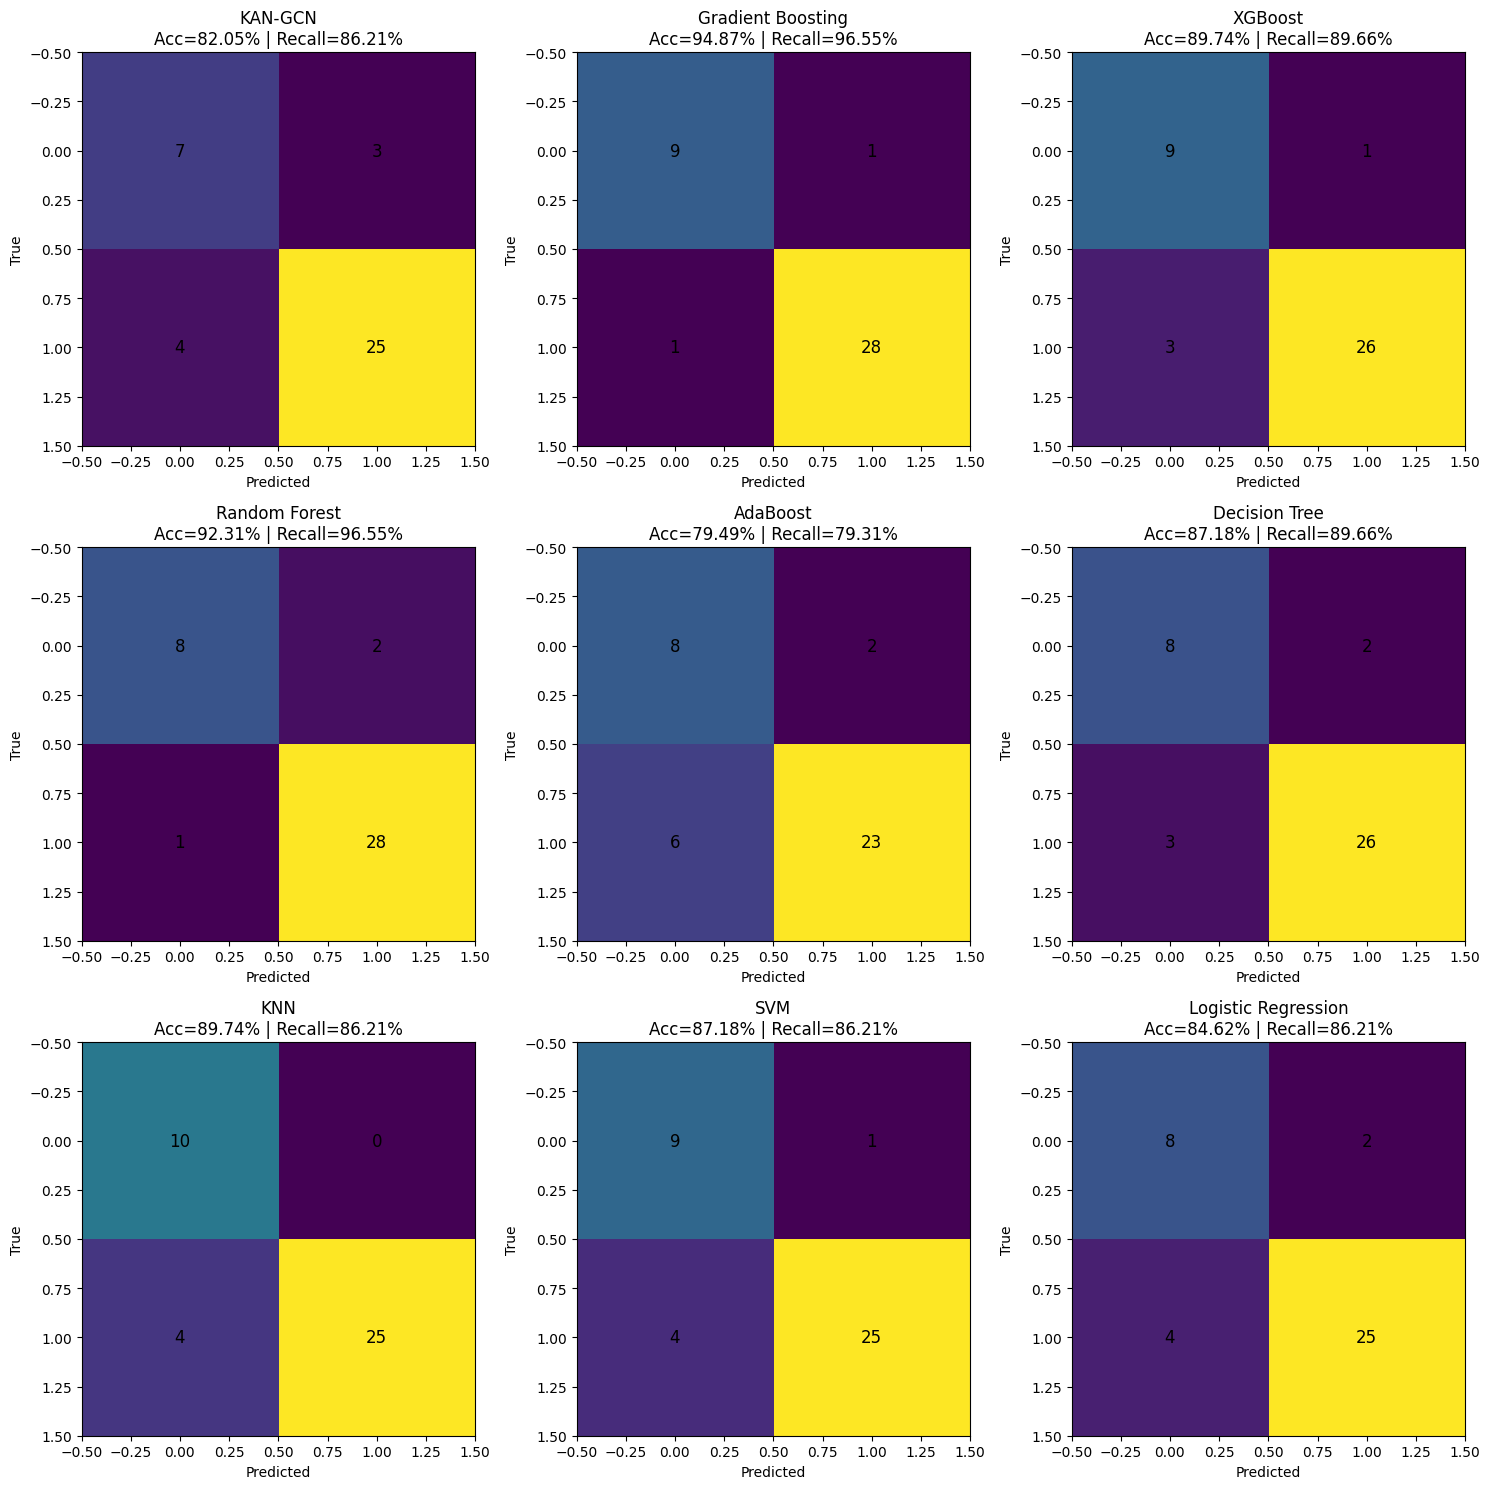

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

models_preds = all_models_preds

n_models = len(models_preds)
cols = 3
rows = int(np.ceil(n_models / cols))

plt.figure(figsize=(15, 5 * rows))

for i, (name, (preds, probs)) in enumerate(models_preds.items()):
    cm = confusion_matrix(y_te_true, preds)

    acc = accuracy_score(y_te_true, preds)*100
    rec = recall_score(y_te_true, preds)*100

    plt.subplot(rows, cols, i+1)
    plt.imshow(cm)

    plt.title(f"{name}\nAcc={acc:.2f}% | Recall={rec:.2f}%")

    plt.xlabel("Predicted")
    plt.ylabel("True")

    for x in range(2):
        for y in range(2):
            plt.text(y, x, cm[x, y], ha="center", va="center", fontsize=12)

plt.tight_layout()
plt.show()


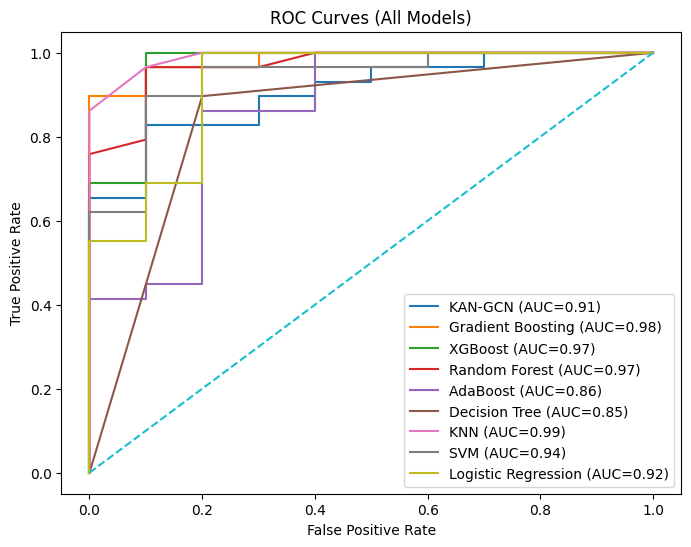

In [33]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, (_, probs) in all_models_preds.items():
    fpr, tpr, _ = roc_curve(y_te_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (All Models)")
plt.legend()
plt.show()
